# Notebook_02: Curve Fitting

The objective of this notebook is to take the preprocessed data csv file extracted using data_preprocess.py on the raw excel files, create the required polynomial features to fit the curve given in the paper.

Then I want to evaluate some error metrics on that curve to act as a baseline comparison to any model or optimisation I come up with later.

## Imports & Setup

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

project_root = Path().resolve().parent
interim_path = project_root / 'Data' / 'Interim'

data_path = interim_path / 'processed_combined.csv'
coef_path = interim_path / 'paper_poly_coefs.csv'

## Curve given in Paper


<img src="../Figures/paper_freq_curve.png" width="800"/>

The curve above is for the 5mm crack position and from the frequency experiments

It is given by the following equation:

$
t_c = A + B\Delta\omega_{nc} + CT + D\Delta\omega_{nc}^2 + E\Delta\omega_{nc}T + F{T^2} + G\Delta\omega_{nc}^3 + H\Delta\omega_{nc}^2 T + I\Delta\omega_{nc} {T^2}
$

Where A through I are the polynomial weighting coefficients

## Replicating the curve

So to replicate this curve I need to:

* Load the preprocessed data

* Generate the polynomial features

* Calculate the predicted polynomial $t_c$ value based on these features

* Check everything is correct

* Plot the curve and compare shape to the paper curve

* Evaluate error metrics for this curve vs measurements (RMSE for example) as a baseline accuracy metric to judge future models or improvements

### Load Preprocessed Data

In [2]:
df = pd.read_csv(data_path)

In [3]:
df

,x,CD/t,temp,nf_hz,nf_drop,amp_mm,amp_drop
0,5,0.000000,22,40.970000,0.000000,12.010000,0.000000
1,5,0.166667,22,38.460000,2.510000,12.290000,-0.280000
2,5,0.170000,22,38.360000,2.610000,10.470000,1.540000
3,5,0.173333,22,38.380000,2.590000,9.880000,2.130000
4,5,0.250000,22,37.480877,3.489123,12.786667,-0.776667
...,...,...,...,...,...,...,...
175,25,0.500000,200,32.472500,8.497500,17.736250,-5.726250
176,25,0.583333,200,30.274583,10.695417,18.053958,-6.043958
177,25,0.666667,200,28.076667,12.893333,18.371667,-6.361667
178,25,0.750000,200,25.878750,15.091250,18.689375,-6.679375


In [4]:
# Get just the rows corresponding to the 5mm crack position so we are consistent with the published curve

df_5 = df.loc[df['x'] == 5]

In [5]:
df_5.head()

,x,CD/t,temp,nf_hz,nf_drop,amp_mm,amp_drop
0,5,0.000000,22,40.970000,0.000000,12.010000,0.000000
1,5,0.166667,22,38.460000,2.510000,12.290000,-0.280000
2,5,0.170000,22,38.360000,2.610000,10.470000,1.540000
3,5,0.173333,22,38.380000,2.590000,9.880000,2.130000
4,5,0.250000,22,37.480877,3.489123,12.786667,-0.776667


In [6]:
# To generate the polynomial features, we actually only need frequency drop, temperature and CD/t
df_5_dropped = df_5.drop(['x', 'nf_hz', 'amp_mm', 'amp_drop'], axis = 1)

In [7]:
df_5_dropped.head()

,CD/t,temp,nf_drop
0,0.000000,22,0.000000
1,0.166667,22,2.510000
2,0.170000,22,2.610000
3,0.173333,22,2.590000
4,0.250000,22,3.489123


In [8]:
# Isolate just the features
X = df_5_dropped[['temp', 'nf_drop']]

# Reorder columns
X = X[['nf_drop', 'temp']]

### Generate Polynomial Features

In [9]:
# Generate the polynomial features
poly_features = PolynomialFeatures(degree = 3, include_bias = False)
X_poly = poly_features.fit_transform(X)

In [10]:
# Purely to visualise in the notebook and check the features are correct
X_poly_df = pd.DataFrame(X_poly)
X_poly_df.head()

,0,1,2,3,4,5,6,7,8
0,0.000000,22.0,0.000000,0.000000,484.0,0.000000,0.000000,0.000000,10648.0
1,2.510000,22.0,6.300100,55.220000,484.0,15.813251,138.602200,1214.840000,10648.0
2,2.610000,22.0,6.812100,57.420000,484.0,17.779581,149.866200,1263.240000,10648.0
3,2.590000,22.0,6.708100,56.980000,484.0,17.373979,147.578200,1253.560000,10648.0
4,3.489123,22.0,12.173978,76.760702,484.0,42.476504,267.827515,1688.735439,10648.0


Equation for reference...

$
t_c = A + B\Delta\omega_{nc} + CT + D\Delta\omega_{nc}^2 + E\Delta\omega_{nc}T + F{T^2} + G\Delta\omega_{nc}^3 + H\Delta\omega_{nc}^2 T + I\Delta\omega_{nc} {T^2}
$

Looks as if the columns are as follows:

0 = $\Delta\omega_{nc}$

1 = $T$

2 = $\Delta\omega_{nc}^2$

3 = $\Delta\omega_{nc}T$

4 = $T^2$

5 = $\Delta\omega_{nc}^3$

6 = $\Delta\omega_{nc}^2 T$

7 = $\Delta\omega_{nc} T^2$

8 = $T^3$

In other words, our polynomial features perfectly match the features given by the equation. With the exception of T^3 which we can drop to match the curve.


In [11]:
# Drop the T cubed
X_poly_df.drop(8, axis = 1, inplace = True)

In [12]:
X_poly_df.head()

,0,1,2,3,4,5,6,7
0,0.000000,22.0,0.000000,0.000000,484.0,0.000000,0.000000,0.000000
1,2.510000,22.0,6.300100,55.220000,484.0,15.813251,138.602200,1214.840000
2,2.610000,22.0,6.812100,57.420000,484.0,17.779581,149.866200,1263.240000
3,2.590000,22.0,6.708100,56.980000,484.0,17.373979,147.578200,1253.560000
4,3.489123,22.0,12.173978,76.760702,484.0,42.476504,267.827515,1688.735439


In [13]:
# Load the coefs df
coefs = pd.read_csv(coef_path)
coefs = coefs[coefs['Mode'] == 'Frequency']['5mm']

In [14]:
# Isolate A as it is a constant and does not need to be included in the matrix math
A = coefs.iloc[0]

In [15]:
A

0.9367

In [16]:
coefs = coefs[1:]
coefs

1    0.359000
2   -0.014330
3   -0.016370
4   -0.001936
5    0.000134
6   -0.000147
7    0.000207
8   -0.000013
Name: 5mm, dtype: float64

### Calculate the predicted $t_c$ based on the Poly Features

So now we have our features in a matrix, and our coefficients in a matrix, all in the right order.

Calculating the predicted $t_c$ is now just a matter of a dot product operation on the two matrices.

In [17]:
feat_matrix = X_poly_df.values
coef_matrix = coefs.values

In [18]:
tc_pred = A + np.dot(feat_matrix, coef_matrix)

In [19]:
# Add these predicted tc values into the df_5 dataframe

df_5_dropped['tc_pred'] = tc_pred

In [20]:
df_5_dropped

,CD/t,temp,nf_drop,tc_pred
0,0.000000,22,0.000000,0.686199
1,0.166667,22,2.510000,1.387904
2,0.170000,22,2.610000,1.412578
3,0.173333,22,2.590000,1.407664
4,0.250000,22,3.489123,1.618229
5,0.333333,22,4.388246,1.807191
6,0.416667,22,5.765882,2.053345
7,0.500000,22,7.329608,2.266551
8,0.583333,22,9.648261,2.446165
9,0.666667,22,12.322174,2.437973


### Plot the Curve

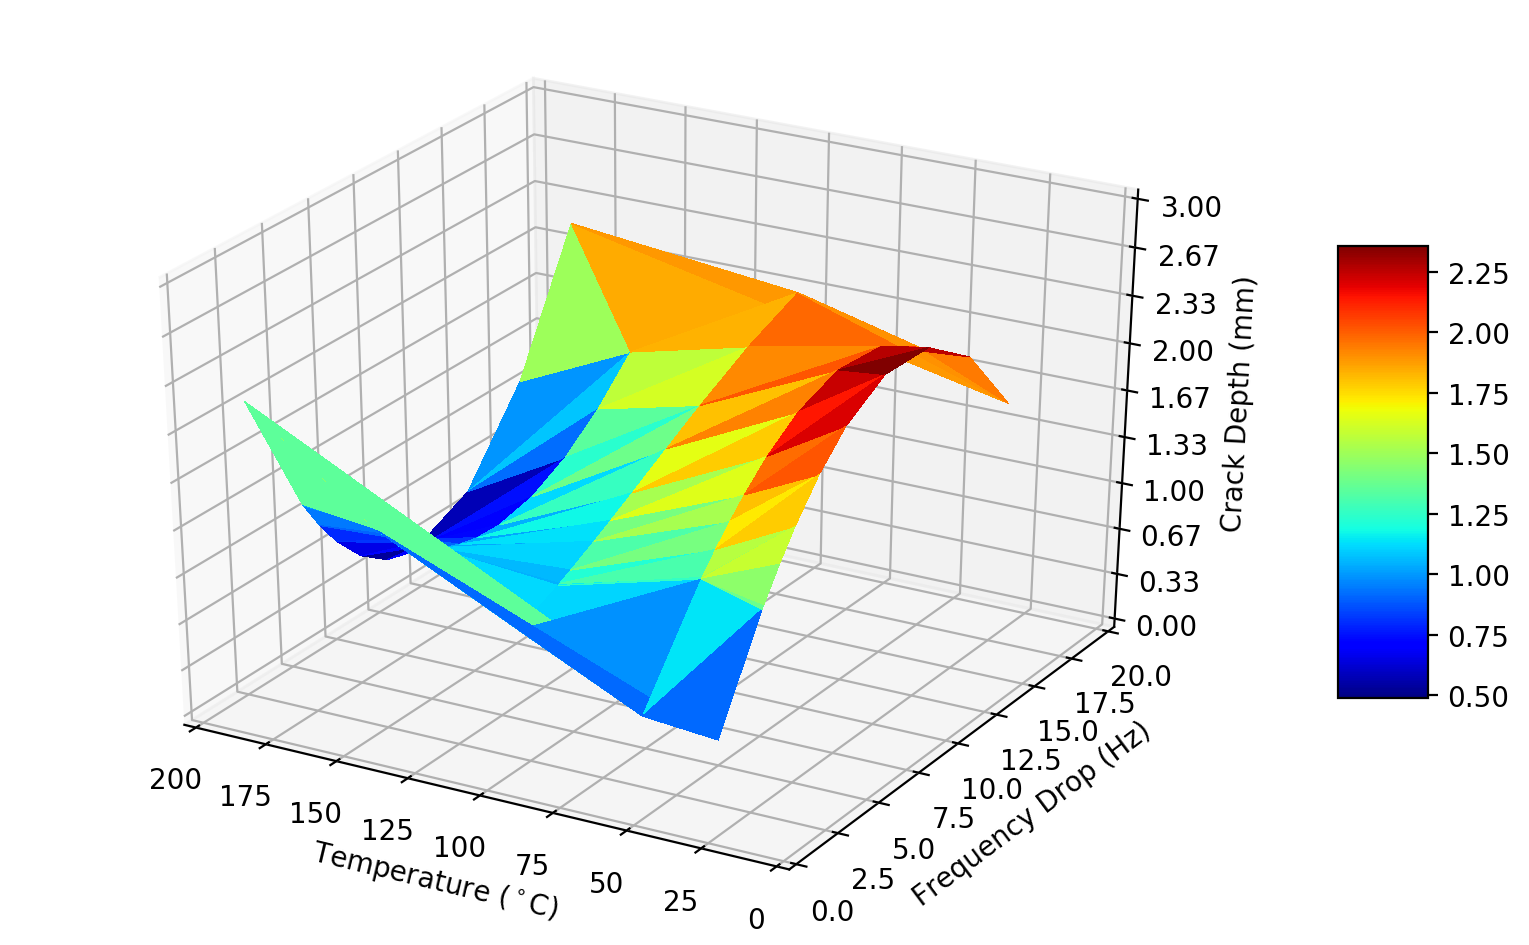

In [21]:
fig = plt.figure(figsize = (10, 6), dpi = 200)
ax = fig.gca(projection = '3d')

X = df_5_dropped['temp']
Y = df_5_dropped['nf_drop']
Z = df_5_dropped['tc_pred']

surf = ax.plot_trisurf(X, Y, Z, cmap = cm.jet, linewidth = 0, 
                      antialiased = False)
ax.set_zlim(0.00, 3.00)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlim(200, 0)
ax.set_ylim(0, 20)

plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Frequency Drop (Hz)')
ax.set_zlabel('Crack Depth (mm)')

fig.colorbar(surf, shrink = 0.5, aspect = 5)

plt.show()
fig.savefig(fname = Path('../Figures/poly5mmcurve.png'), dpi = 300)

That looks pretty close! Ignoring the format difference and the jagged nature (because I plotted it only on the actual data points with no interpolation)

<img src="../Figures/paper_freq_curve.png" width="800"/>

So now we know that this method works and produces the same curve shown in the paper, we can now do this with all the coefficients for all crack positions and for both frequency and amplitude.

This will give us tc_pred for all measured data points.

From here we can get some error metrics for the whole dataset.

Probably best to do that in a new notebook though... my brain hurts!